# IBM Data Science Professional Certificate - Capstone Project

Author: Carl-Michael Edeling

##### This final project demonstrates the skills and knowledge gained during the course.

In [575]:
import pandas as pd
import numpy as np
import requests

In [576]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


---

# Webscraping - Toronto Neighbourhood Data

Convert contents from URL to Data Frame.

In [577]:
urlwiki1 = "https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050."
list = pd.read_html(urlwiki1)
type(list)

list

In [578]:
len(list)

3

In [579]:
list[0][0:5]

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


The first table is the one we're interested in.  So assign it to the "table" variable.

In [580]:
table = list[0]
table.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


We need to drop the rows that have unassigned Boroughs.

In [581]:
# get names of indexes for which column Borough has value "Not assigned"
index_names = table[table['Borough'] == 'Not assigned'].index
  
# drop these row indexes from dataFrame
table.drop(index_names, inplace = True)
  
table.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor


The index needs to be reset.

In [582]:
table.reset_index(inplace=False).head()

,index,Postcode,Borough,Neighbourhood
0,2,M3A,North York,Parkwoods
1,3,M4A,North York,Victoria Village
2,4,M5A,Downtown Toronto,Harbourfront
3,5,M6A,North York,Lawrence Heights
4,6,M6A,North York,Lawrence Manor


Check to see if any neighbourhoods are "Not assigned"

In [583]:
table[table['Neighbourhood'] == 'Not assigned'].count()

Postcode         0
Borough          0
Neighbourhood    0
dtype: int64

There are no unassigned Neighbourhoods

So now we need to group neighbourhoods together with postal code and boroughs.

In [584]:
table_grouped = table.groupby(['Postcode','Borough'])['Neighbourhood'].apply(', '.join).reset_index()
table_grouped.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Let's see the shape of the new dataframe.

In [585]:
print("The shape is: ", table_grouped.shape)

The shape is:  (103, 3)


---

# Combining Dataframe with Geospatial Data

In [586]:
geo = pd.read_csv(r"C:\A - Work\Courses\Data Science - IBM\Lessons\10 - Applied Data Science Capstone\Final Assignment\Geospatial_Coordinates.csv")

In [587]:
geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [588]:
print("The shape is: ", geo.shape)

The shape is:  (103, 3)


But this dataframe also has a column for Postal Code, so let's drop it.

In [589]:
geo1 = geo.drop(labels='Postal Code', axis=1, index=None, columns=None, level=None, inplace=False, errors='raise')
geo1.head()

,Latitude,Longitude
0,43.806686,-79.194353
1,43.784535,-79.160497
2,43.763573,-79.188711
3,43.770992,-79.216917
4,43.773136,-79.239476


In [590]:
# Join the 2 dfs
frames = [table_grouped, geo1]

In [591]:
comb_table = pd.concat(
    frames,
    axis=1,
    join="outer",
    ignore_index=False,
    keys=None,
    levels=None,
    names=None,
    verify_integrity=False,
    copy=True,
)

In [592]:
comb_table.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [593]:
print("The shape is: ", comb_table.shape)

The shape is:  (103, 5)


---

# Clustering

Import needed Libraries

In [594]:
import os
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


#### Create a map of Toronto with neighbourhoods superimposed on top.

In [595]:
from geopy.geocoders import ArcGIS

address = 'Toronto'

geolocator = ArcGIS(scheme="https")     # Problem was using Nominatim.  Also, ArcGIS(scheme="http") DIDN'T work.
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.648690000000045, -79.38543999999996.


In [596]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbourhood in zip(comb_table['Latitude'], 
                                           comb_table['Longitude'], 
                                           comb_table['Borough'], 
                                           comb_table['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

---

Get nearby venues for each neighbourhood.

In [597]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [598]:
toronto_venues = getNearbyVenues(names=comb_table['Neighbourhood'],
                                   latitudes=comb_table['Latitude'],
                                   longitudes=comb_table['Longitude'])

In [599]:
print("The shape is: ", toronto_venues.shape)
toronto_venues.head()

The shape is:  (2114, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Chris Effects Painting,43.784343,-79.163742,Construction & Landscaping
2,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


Let's check how many venues were returned for each neighborhood


In [600]:
total_venue_categories = toronto_venues.groupby('Neighbourhood').count()

In [601]:
total_venue_categories.head()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"Adelaide, King, Richmond",92,92,92,92,92,92
Agincourt,4,4,4,4,4,4
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",3,3,3,3,3,3
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",9,9,9,9,9,9
"Alderwood, Long Branch",7,7,7,7,7,7


In [602]:
print("The total number of venues = ", sum(total_venue_categories["Venue"]))

The total number of venues =  2114


In [603]:
print('There are {} uniques venues.'.format(len(toronto_venues['Venue'].unique())))

There are 1381 uniques venues.


In [604]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 274 uniques categories.


---

# Analyzing each neighbourhood

In [ ]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

In [606]:
toronto_onehot.shape

(2114, 275)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category


In [607]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head()

,Neighbourhood,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01087,0.

In [608]:
toronto_grouped.shape

(99, 275)

#### Let's print the first 5 neighbourhoods along with the top 5 most common venues

In [609]:
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood'][0:5]:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
            venue  freq
0     Coffee Shop  0.11
1            Café  0.05
2      Restaurant  0.04
3             Gym  0.03
4  Clothing Store  0.03


----Agincourt----
                       venue  freq
0               Skating Rink  0.25
1                     Lounge  0.25
2             Breakfast Spot  0.25
3  Latin American Restaurant  0.25
4          Accessories Store  0.00


----Agincourt North, L'Amoreaux East, Milliken, Steeles East----
                venue  freq
0        Intersection  0.33
1          Playground  0.33
2                Park  0.33
3  Miscellaneous Shop  0.00
4               Motel  0.00


----Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown----
            venue  freq
0   Grocery Store  0.22
1     Pizza Place  0.11
2  Sandwich Place  0.11
3        Pharmacy  0.11
4    Liquor Store  0.11


----Alderwood, Long Branch----
          venue  freq
0   Pizza Place  0.29
1           Gym  

A function to sort the venues in descending order.

In [610]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the top 10 venues for each neighbourhood.

In [611]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Restaurant,Gym,Thai Restaurant,Deli / Bodega,Clothing Store,Hotel,Bookstore,Sushi Restaurant
1,Agincourt,Lounge,Latin American Restaurant,Breakfast Spot,Skating Rink,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Intersection,Park,Playground,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Beer Store,Fried Chicken Joint,Fast Food Restaurant,Liquor Store,Pizza Place,Sandwich Place,Pharmacy,American Restaurant,Falafel Restaurant
4,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Sandwich Place,Gym,Skating Rink,Pub,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner


# Cluster Neighbourhoods

Run _k_-means to cluster the neighbourhood into 10 clusters.


In [612]:
# set number of clusters
kclusters = 10

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

test_kmeans = KMeans(n_clusters=kclusters, 
                init='k-means++', 
                n_init=100,
                max_iter=5000,
                tol=0.001, 
                random_state=12)
test_labels = test_kmeans.fit_predict(toronto_grouped_clustering) #toronto_grouped_clustering
test_labels

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 8, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 3, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       9, 0, 1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 1, 9, 1, 1, 1, 1, 1, 1, 1, 1,
       5, 1, 1, 1, 4, 1, 1, 1, 1, 1, 8])

### What is the optimal value of k?

I tried to calculate the efficacy of using various numbers of clusters, ranging from 2 to 20.

I tried 3 methods:

1. Method - model.score()
2. Attribute - model.inertia_
3. Function - calculate the WSS score.  Unfortunately I couldn't get this function to work.

#### Using .score() 

"Opposite of the value of X on the K-means objective."

By comparing it to inertia, it gives the negative of the inertia.

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [613]:
kclusters = 20
kscores = []
for k in range(2, kclusters):
    kscore = KMeans(n_clusters=k, 
                init='k-means++', 
                n_init=100,
                max_iter=3000,
                tol=0.01, 
                random_state=7).fit(toronto_grouped_clustering).score(toronto_grouped_clustering, 
                                                                      y=None, 
                                                                      sample_weight=None)
    kscores.append(kscore)
    #print(kscore1)
#print(kscore)

#### Using .inertia_

"Sum of squared distances of samples to their closest cluster center."

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [614]:
kclusters = 20
kinertia = []
for k in range(2, kclusters):
    kscore = KMeans(n_clusters=k, 
                init='k-means++', 
                n_init=100,
                max_iter=3000,
                tol=0.01, 
                random_state=7).fit(toronto_grouped_clustering)
    kinertia.append(kscore.inertia_)
    #print(kscore1)
#print(kscore)


"test_kmeans = KMeans(n_clusters=kclusters, \n                init='k-means++', \n                n_init=100,\n                max_iter=5000,\n                tol=0.001, \n                random_state=12)\ntest_labels = test_kmeans.fit_predict(toronto_grouped_clustering) #toronto_grouped_clustering\ntest_labels"

In [615]:
kinertia

[17.27356086917493,
 16.069586259042115,
 15.066245048260328,
 14.195750384499684,
 13.317630181112898,
 12.822100341649596,
 11.840783567755736,
 11.3681176520682,
 11.053144707450816,
 10.685104827774838,
 10.435104827774838,
 10.127234457404468,
 9.696902376694661,
 9.446415311154254,
 9.26895631801666,
 8.964856254583761,
 8.576819031330533,
 8.33861720219025]

In [616]:
kscores

[-17.27356086917493,
 -16.069586259042115,
 -15.066245048260328,
 -14.195750384499684,
 -13.317630181112898,
 -12.822100341649596,
 -11.840783567755736,
 -11.3681176520682,
 -11.053144707450816,
 -10.685104827774836,
 -10.435104827774836,
 -10.12723445740447,
 -9.696902376694661,
 -9.446415311154254,
 -9.26895631801666,
 -8.964856254583761,
 -8.576819031330533,
 -8.33861720219025]

Let's graph number of clusters against kscores and kinertia

In [617]:
x = np.linspace(2, 19, 18)

Text(0, 0.5, 'k-Means Scores')

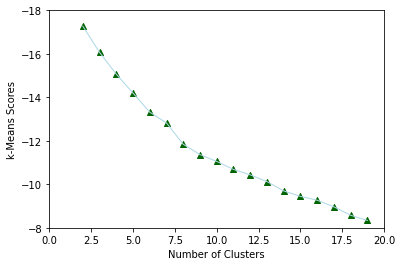

In [618]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot()
ax.set(xlim=[0,20],ylim=[-8,-18])
#plt.xlim([2, 20])
ax.plot(x, kscores, color='lightblue', linewidth=1)
ax.scatter(x,kscores,
color='darkgreen',
marker='^')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("k-Means Scores")


Text(0, 0.5, 'Inertia Scores')

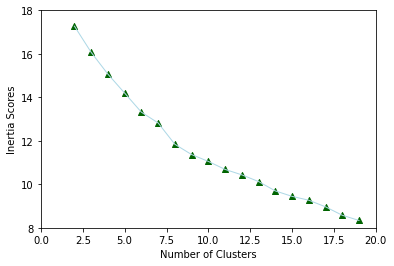

In [619]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot()
ax.set(xlim=[0,20],ylim=[8,18])
ax.plot(x, kinertia, color='lightblue', linewidth=1)
ax.scatter(x,kinertia,
color='darkgreen',
marker='^')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Inertia Scores")

Unfortuantely there is a poorly defined "elbow-point" on both graphs, so it is difficult to tell.  It appears that the "elbow point" is around 9 clusters.

Now, let's run the algorithm again with the optimal number of clusters: 9

In [620]:
# set number of clusters
kclusters = 9

kmeans_8_model = KMeans(n_clusters=kclusters, 
                init='k-means++', 
                n_init=100,
                max_iter=5000,
                tol=0.001, 
                random_state=12)
kmeans_8 = kmeans_8_model.fit_predict(toronto_grouped_clustering)
kmeans_8

array([3, 0, 7, 3, 3, 3, 0, 3, 3, 0, 3, 3, 0, 7, 0, 3, 7, 3, 0, 3, 0, 3,
       3, 0, 3, 0, 3, 3, 0, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 3, 7, 5, 3, 3,
       3, 0, 0, 0, 0, 3, 3, 0, 8, 0, 0, 5, 0, 0, 7, 0, 3, 3, 7, 3, 0, 0,
       6, 7, 3, 0, 3, 3, 7, 3, 7, 0, 1, 3, 3, 6, 3, 3, 0, 3, 0, 0, 3, 0,
       4, 3, 3, 3, 2, 3, 3, 3, 0, 0, 7])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighbourhood.


In [621]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans_8_model.labels_)

toronto_merged = comb_table

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighbourhood
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

In [622]:
toronto_merged.head(5)

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1.0,Fast Food Restaurant,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore,Falafel Restaurant
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,8.0,Bar,Construction & Landscaping,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0.0,Electronics Store,Intersection,Breakfast Spot,Bank,Restaurant,Medical Center,Donut Shop,Rental Car Location,Mexican Restaurant,Discount Store
3,M1G,Scarborough,Woburn,43.770992,-79.216917,3.0,Coffee Shop,Korean BBQ Restaurant,Mexican Restaurant,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,Bank,Hakka Restaurant,Fried Chicken Joint,Caribbean Restaurant,Thai Restaurant,Athletics & Sports,Gas Station,Bakery,Distribution Center,Dim Sum Restaurant


Finally, let's visualize the resulting clusters


In [623]:
toronto_merged[toronto_merged["Cluster Labels"] == 1].head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1.0,Fast Food Restaurant,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore,Falafel Restaurant


In [624]:
toronto_merged[toronto_merged['Cluster Labels'].isna()]

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,M1X,Scarborough,Upper Rouge,43.836125,-79.205636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,M2L,North York,"Silver Hills, York Mills",43.757490,-79.374714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,M9B,Etobicoke,"Cloverdale, Islington, Martin Grove, Princess ...",43.650943,-79.554724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [625]:
toronto_merged = toronto_merged.dropna(axis = 0, how = 'any')
toronto_merged.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1.0,Fast Food Restaurant,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore,Falafel Restaurant
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,8.0,Bar,Construction & Landscaping,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0.0,Electronics Store,Intersection,Breakfast Spot,Bank,Restaurant,Medical Center,Donut Shop,Rental Car Location,Mexican Restaurant,Discount Store
3,M1G,Scarborough,Woburn,43.770992,-79.216917,3.0,Coffee Shop,Korean BBQ Restaurant,Mexican Restaurant,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,Bank,Hakka Restaurant,Fried Chicken Joint,Caribbean Restaurant,Thai Restaurant,Athletics & Sports,Gas Station,Bakery,Distribution Center,Dim Sum Restaurant


In [626]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], 
                                  toronto_merged['Longitude'], 
                                  toronto_merged['Neighbourhood'], 
                                  toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters